In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import srsly
import seaborn as sns
import re

# load the annotation data file
df = pd.read_csv('../assets/annotations.csv')

# load the text corpus
docs = list(srsly.read_jsonl('../corpus/corpus.jsonl'))

# set the default font for everything so chinese characters display correctly
matplotlib.rcParams['font.family'] = "Heiti TC"
matplotlib.rcParams.update({'font.size': 14})

# Annotation targets — headwords/graphs
* What length segments of text are annotated in the _Jingdian Shiwen_?
* What characters are most frequently annotated?
* Which texts are densely annotated, relative to their length?

Average characters per annotation: 20.12436447073122


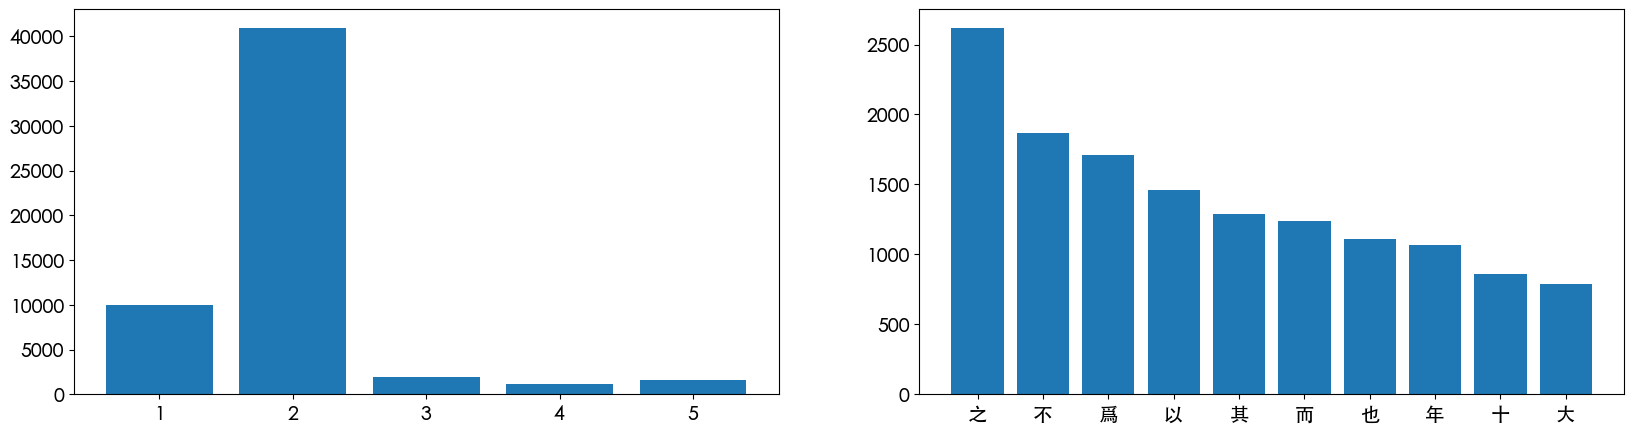

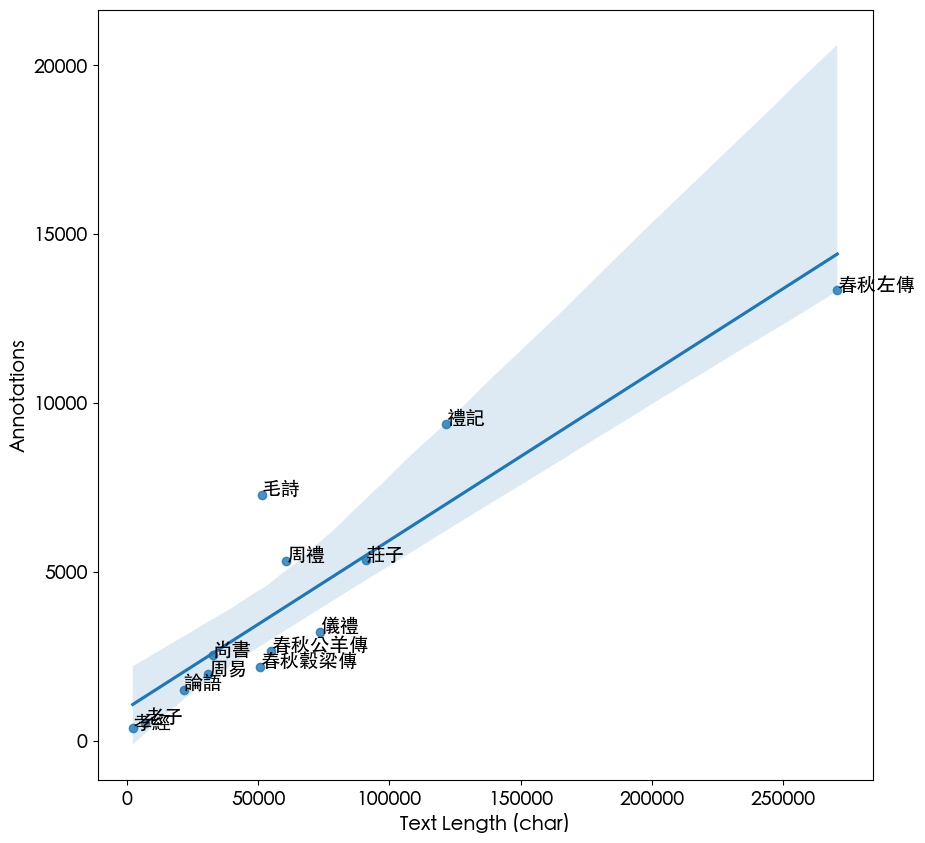

In [3]:

# calculate and plot headword lengths
figure = plt.figure(figsize=(20, 5))
len_counts, len_bins = np.histogram(df['headword'].str.len(), bins=[1, 2, 3, 4, 5, np.Infinity])
head_length_plt = figure.add_subplot(121)
head_length_plt.bar(len_bins[:-1], len_counts)

# calculate and plot most frequent characters in headwords
head_chars = Counter(char for head in df['headword'] for char in head).most_common(10)
head_chars_plt = figure.add_subplot(122)
head_chars_plt.bar([char[0] for char in head_chars], [char[1] for char in head_chars])

# compare total citations vs. text length
figure2 = plt.figure(figsize=(10, 10))
texts = Counter(df['title']).most_common()
text_lengths = Counter()
for doc in docs:
    text_lengths[doc['meta']['doc_title']] += len(doc['text'])
df_plot = pd.DataFrame({'title': [text[0] for text in texts], 'citations': [text[1] for text in texts], 'length': [text_lengths[text[0]] for text in texts]})
ax = sns.regplot(x='length', y='citations', data=df_plot)
ax.set(xlabel='Text Length (char)', ylabel='Annotations')
for title, count in texts:
    ax.annotate(title, (text_lengths[title], count))
density_fn = np.polyfit(df_plot['length'], df_plot['citations'], 1)
print('Average characters per annotation: {}'.format(1 / density_fn[0]))



# Annotation forms
* What is the distribution of annotation lengths?
* What are the most common forms of annotation?
* What patterns occur frequently within annotations?

Text(0, 0.5, 'Count')

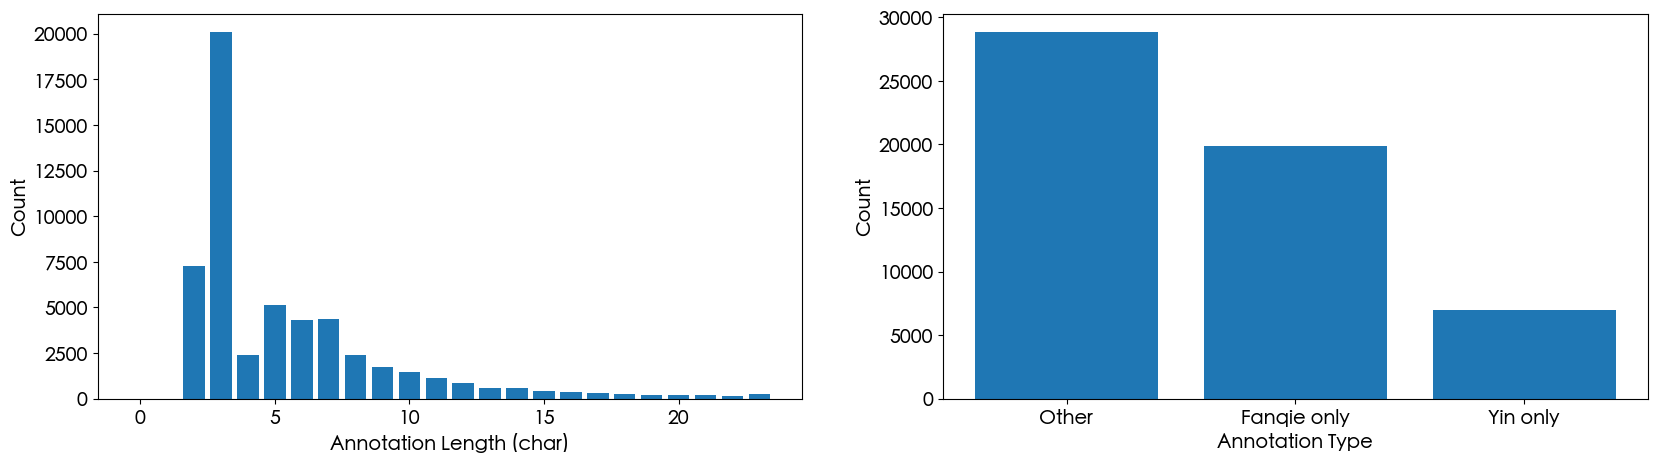

In [9]:
# plot the distribution of annotation lengths
anno_fig = plt.figure(figsize=(20, 5))
len_counts, len_bins = np.histogram(df['annotation'].str.len(), bins=range(0, 25))
anno_length_plt = anno_fig.add_subplot(121)
anno_length_plt.bar(len_bins[:-1], len_counts)
anno_length_plt.set_xlabel('Annotation Length (char)')
anno_length_plt.set_ylabel('Count')

# plot the distribution of annotation types
yin_re = re.compile(r'^音\S$')
fanqie_re = re.compile(r'^\S{2}反$')

def get_anno_type(anno):
    if yin_re.match(anno):
        return 'Yin only'
    elif fanqie_re.match(anno):
        return 'Fanqie only'
    else:
        return 'Other'

df['type'] = df['annotation'].apply(get_anno_type)
anno_type_plt = anno_fig.add_subplot(122)
type, count = df['type'].value_counts().index, df['type'].value_counts().values
anno_type_plt.bar(type, count)
anno_type_plt.set_xlabel('Annotation Type')
anno_type_plt.set_ylabel('Count')

Text(0, 0.5, 'Count')

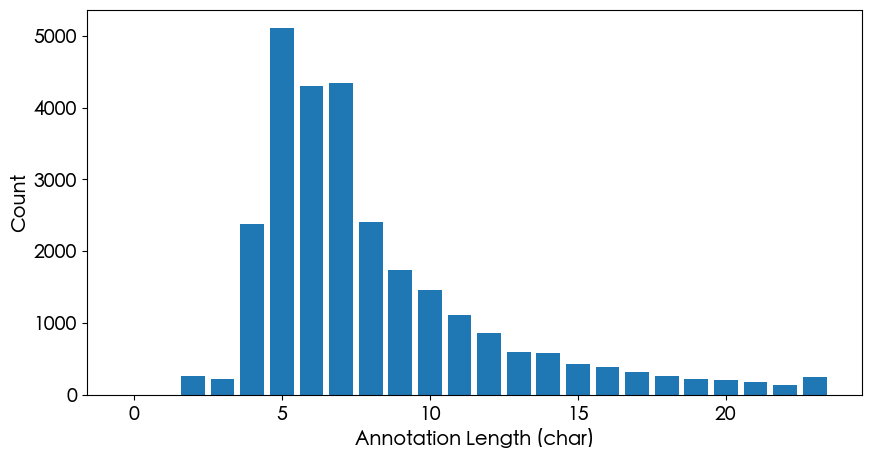

In [5]:
# remove "simple" annotation types, then re-plot the length distribution
complex = df[df['type'] == '其他']
comp_anno_fig = plt.figure(figsize=(10, 5))
len_counts, len_bins = np.histogram(complex['annotation'].str.len(), bins=range(0, 25))
anno_length_plt = comp_anno_fig.add_subplot()
anno_length_plt.bar(len_bins[:-1], len_counts)
anno_length_plt.set_xlabel('Annotation Length (char)')
anno_length_plt.set_ylabel('Count')

# TODO: use some regexes to try to identify quantifiers here

<AxesSubplot:ylabel='quadgram'>

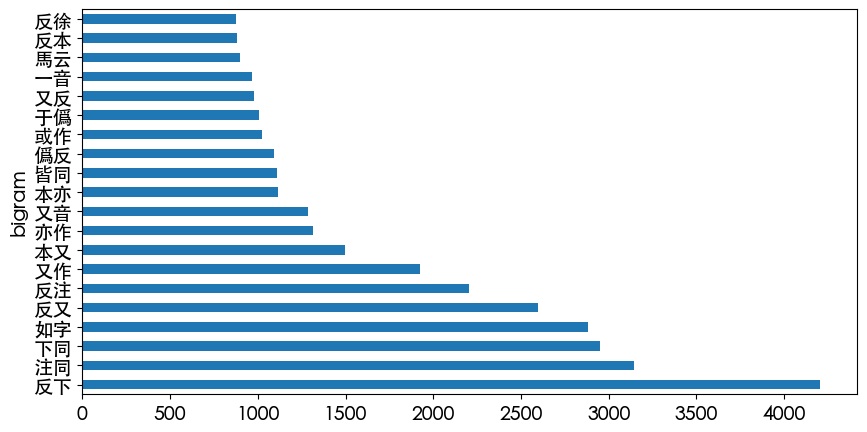

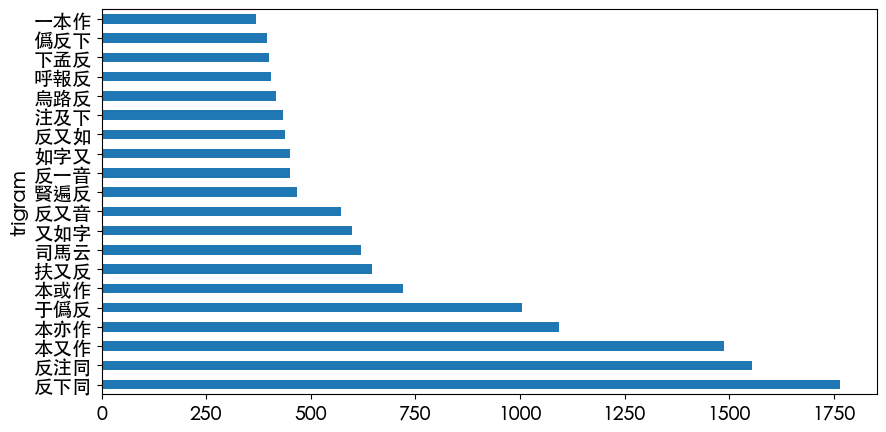

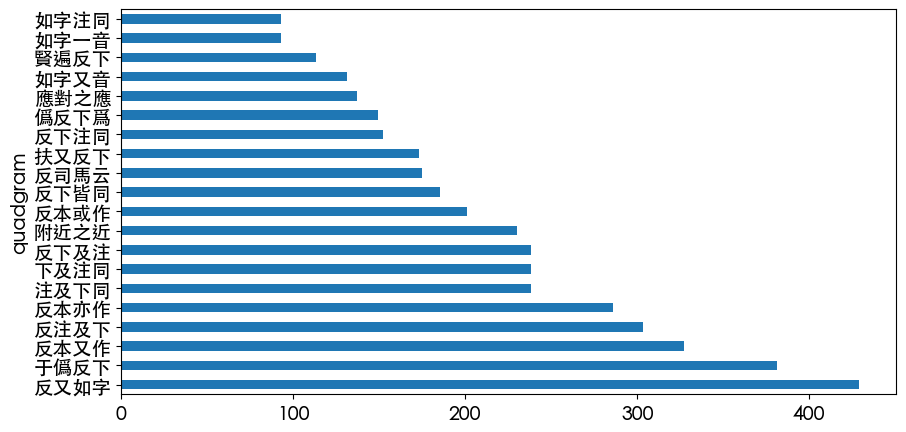

In [24]:
from nltk.util import ngrams

# find the most common n-grams in the annotations
df["bigrams"] = df['annotation'].apply(lambda x: list(ngrams(x, 2)))
df["trigrams"] = df['annotation'].apply(lambda x: list(ngrams(x, 3)))
df["quadgrams"] = df['annotation'].apply(lambda x: list(ngrams(x, 4)))

bigrams = Counter([bigram for bigrams in df['bigrams'] for bigram in bigrams]).most_common(20)
trigrams = Counter([trigram for trigrams in df['trigrams'] for trigram in trigrams]).most_common(20)
quadgrams = Counter([quadgram for quadgrams in df['quadgrams'] for quadgram in quadgrams]).most_common(20)

def print_grams_table(grams, label):
    print(f"| {label} | Count |")
    print("| --- | --- |")
    for gram in grams:
        print("| {} | {} |".format(' '.join(gram[0]), gram[1]))

bigrams_df = pd.DataFrame(bigrams, columns=['bigram', 'count'])
bigrams_df['bigram'] = bigrams_df['bigram'].apply(lambda x: ''.join(x))
bigrams_df = bigrams_df.set_index('bigram')
bigrams_df.plot.barh(figsize=(10, 5), legend=False)

trigrams_df = pd.DataFrame(trigrams, columns=['trigram', 'count'])
trigrams_df['trigram'] = trigrams_df['trigram'].apply(lambda x: ''.join(x))
trigrams_df = trigrams_df.set_index('trigram')
trigrams_df.plot.barh(figsize=(10, 5), legend=False)

quadgrams_df = pd.DataFrame(quadgrams, columns=['quadgram', 'count'])
quadgrams_df['quadgram'] = quadgrams_df['quadgram'].apply(lambda x: ''.join(x))
quadgrams_df = quadgrams_df.set_index('quadgram')
quadgrams_df.plot.barh(figsize=(10, 5), legend=False)